# Exploratory Data Analysis

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

Load and inspect the data:

In [2]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)

In [3]:
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0


* **date:** entry date
* **n_sick:** number of drivers called sick on duty
* **calls:** number of emergency calls
* **n_duty:** number of drivers on duty available
* **n_sby:** number of standby resources available
* **sby_need:** number of standbys, which are activated on a given day
* **dafted:** number of additional drivers needed due to not enough standbys

In [4]:
df.describe()

,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
mean,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
std,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089
min,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000
max,119.000000,11850.000000,1900.000000,90.0,555.000000,465.000000


Check for NaN-values:

In [5]:
df.isnull().values.any()

False

Correlation matrix between all the features we are examining and our y-variable:

In [6]:
corr = df.corr()
print(corr)

            n_sick     calls    n_duty  n_sby  sby_need    dafted
n_sick    1.000000  0.155371  0.459501    NaN  0.022321  0.016800
calls     0.155371  1.000000  0.364135    NaN  0.677468  0.557340
n_duty    0.459501  0.364135  1.000000    NaN  0.090654  0.084955
n_sby          NaN       NaN       NaN    NaN       NaN       NaN
sby_need  0.022321  0.677468  0.090654    NaN  1.000000  0.945168
dafted    0.016800  0.557340  0.084955    NaN  0.945168  1.000000


Correlation heatmap:

<AxesSubplot:>

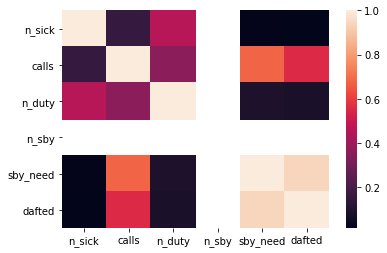

In [7]:
sns.heatmap(df.corr())

Plotting a diagonal correlation heatmap:

<AxesSubplot:>

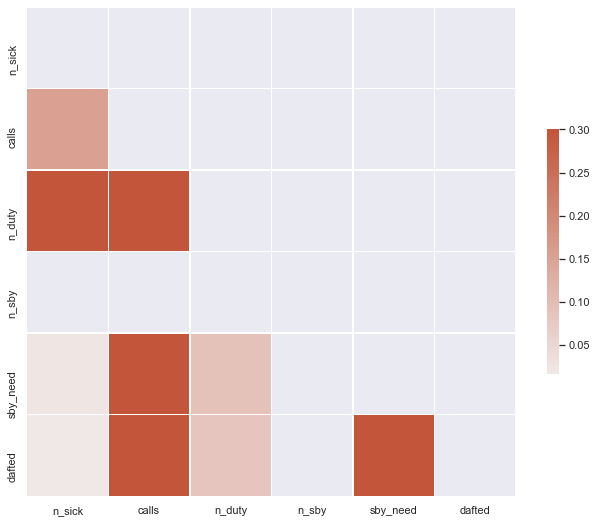

In [8]:
sns.set_theme(style="dark")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

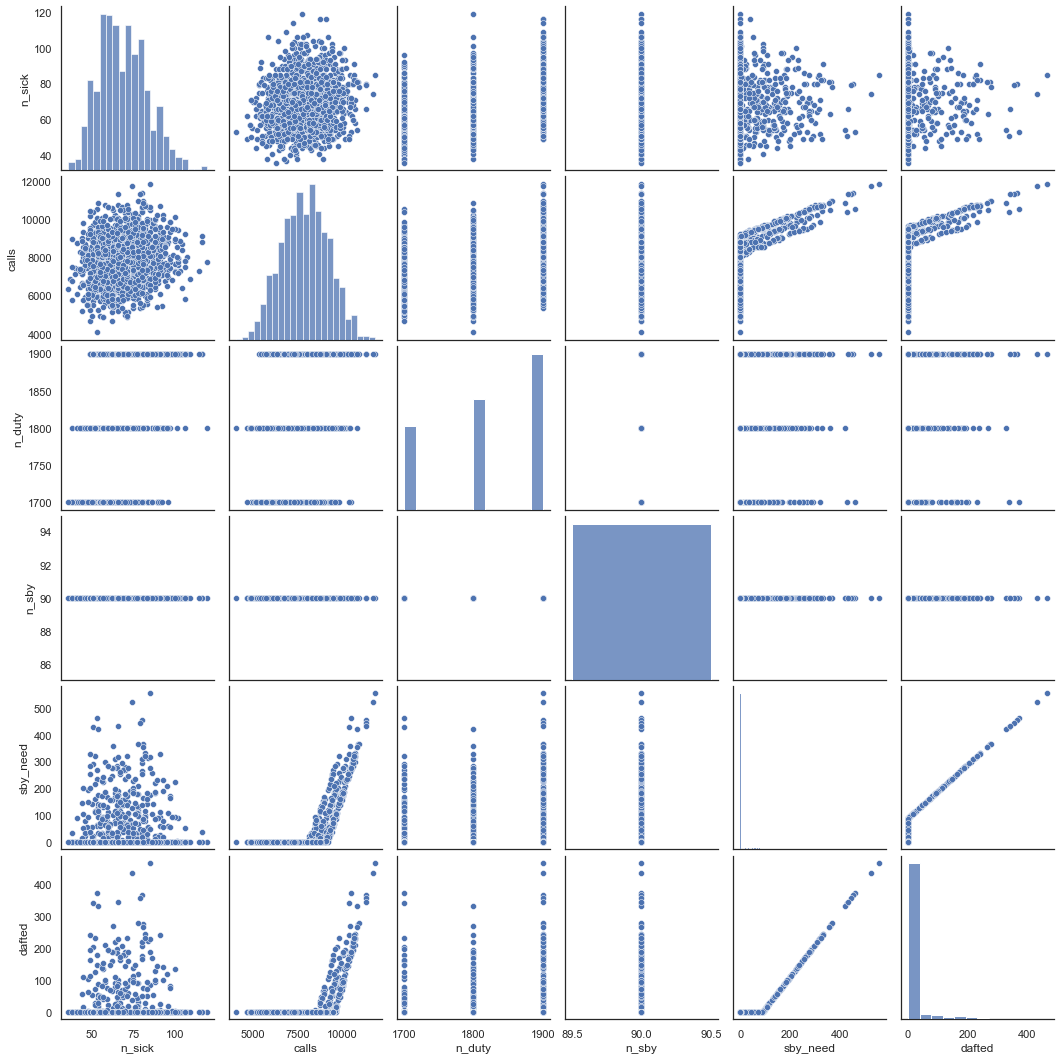

In [9]:
sns.set_theme(style="white")

sns.pairplot(df)

In [10]:
df.n_duty.unique()

array([1700, 1800, 1900])

This means, there is only three options of drivers on duty.

In [11]:
df.n_sby.unique()

array([90])

There are always 90 drivers on standby.

In [12]:
print(df.date.min())
print(df.date.max())

2016-04-01
2019-05-27


The data covers a period of three years, from April 1st 2016 to May 27th 2019.

In [13]:
print(df.calls.min())
print(df.calls.max())
print(df.calls.mean())

4074.0
11850.0
7919.53125


At least 4074 calls were received during the period, maximum 11.850. On average, 7919.53 calls were received.

In [14]:
print(df.sby_need.min())
print(df.sby_need.max())
print(df.sby_need.mean())

0.0
555.0
34.71875


On average, 34.7 drivers are needed on standby. However, since the maximum is 555, it is worth looking for outliers here.

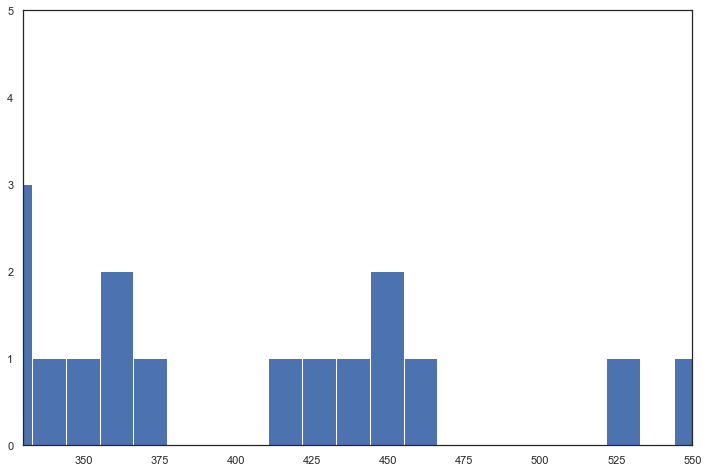

In [15]:
plt.figure(figsize=(12, 8))
plt.clf()
plt.hist(df.sby_need, bins=50)
plt.axis([330, 550, 0, 5])
plt.show()

In [16]:
#???

new_df = df.groupby(['sby_need']).sum()
print(new_df)
type(new_df)

          n_sick      calls   n_duty  n_sby  dafted
sby_need                                           
0.0        58159  6258438.0  1543100  76410     0.0
2.0          206    25998.0     5400    270     0.0
4.0          325    34950.0     7300    360     0.0
5.0           84     9102.0     1900     90     0.0
6.0          160    17754.0     3700    180     0.0
...          ...        ...      ...    ...     ...
445.0         79    11328.0     1900     90   355.0
454.0         80    11370.0     1900     90   364.0
461.0         53    10536.0     1700     90   371.0
523.0         74    11742.0     1900     90   433.0
555.0         85    11850.0     1900     90   465.0

[185 rows x 5 columns]


pandas.core.frame.DataFrame

In [17]:
new_df2 = df.groupby(['sby_need']).size()
print(new_df2)

sby_need
0.0      849
2.0        3
4.0        4
5.0        1
6.0        2
        ... 
445.0      1
454.0      1
461.0      1
523.0      1
555.0      1
Length: 185, dtype: int64


<Figure size 432x288 with 0 Axes>

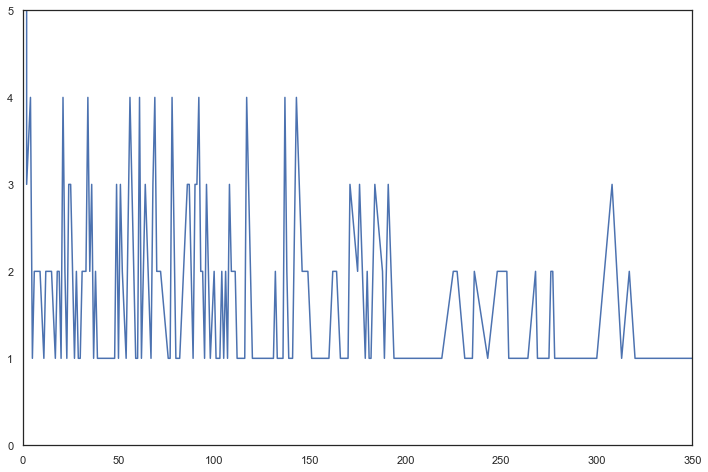

In [18]:

plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(new_df2)
plt.axis([0, 350, 0, 5])
plt.show()

Most of the time no standby drivers were needed, otherwise between 2 and 5. It could become problematic that there are numerous individual cases where hundreds were needed.

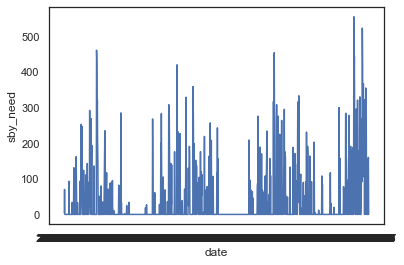

In [19]:
#f, ax = plt.subplots(figsize=(14, 9))

sns.lineplot(x="date", y="sby_need", data=df);

Visualize individual years for clarity:

In [20]:
year2016 = df.head(275)
year2016

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0
...,...,...,...,...,...,...,...
270,2016-12-27,80,6828.0,1700,90,0.0,0.0
271,2016-12-28,91,6096.0,1700,90,0.0,0.0
272,2016-12-29,96,7326.0,1700,90,0.0,0.0
273,2016-12-30,92,5478.0,1700,90,0.0,0.0


In [21]:
year2016.sort_values(by='sby_need', ascending=False, na_position='first').head(15)

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
122,2016-08-01,53,10536.0,1700,90,461.0,371.0
123,2016-08-02,51,10392.0,1700,90,430.0,340.0
125,2016-08-04,52,9840.0,1700,90,320.0,230.0
96,2016-07-06,51,9702.0,1700,90,292.0,202.0
214,2016-11-01,65,9600.0,1700,90,285.0,195.0
101,2016-07-11,70,9492.0,1700,90,269.0,179.0
64,2016-06-04,67,9426.0,1700,90,253.0,163.0
124,2016-08-03,49,9516.0,1700,90,253.0,163.0
66,2016-06-06,62,9426.0,1700,90,248.0,158.0
67,2016-06-07,53,9414.0,1700,90,236.0,146.0


(array([18, 45, 64]),
 [Text(18, 0, '19.4.2016'), Text(45, 0, '16.5.2016'), Text(64, 0, '4.6.2016')])

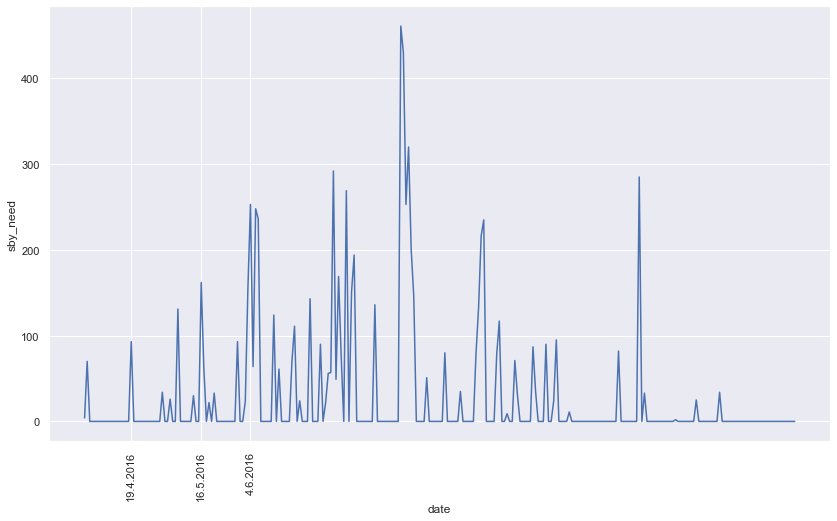

In [22]:
sns.set(rc={'figure.figsize':(14,8)})

sns.lineplot(x="date", y="sby_need", data=year2016)
plt.xticks([18, 45, 64], ['19.4.2016', '16.5.2016', '4.6.2016'])
plt.xticks(rotation=90)

In [23]:
year2017 = df.iloc[276:640]
year2017

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
276,2017-01-02,70,8550.0,1800,90,0.0,0.0
277,2017-01-03,74,8238.0,1800,90,0.0,0.0
278,2017-01-04,76,7902.0,1800,90,0.0,0.0
279,2017-01-05,76,8268.0,1800,90,0.0,0.0
280,2017-01-06,71,6054.0,1800,90,0.0,0.0
...,...,...,...,...,...,...,...
635,2017-12-27,76,6558.0,1800,90,0.0,0.0
636,2017-12-28,81,6978.0,1800,90,0.0,0.0
637,2017-12-29,75,7494.0,1800,90,0.0,0.0
638,2017-12-30,71,6432.0,1800,90,0.0,0.0


In [24]:
year2018 = df.iloc[640:1005]
year2018

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
640,2018-01-01,64,9006.0,1900,90,0.0,0.0
641,2018-01-02,75,7224.0,1900,90,0.0,0.0
642,2018-01-03,74,6480.0,1900,90,0.0,0.0
643,2018-01-04,80,6756.0,1900,90,0.0,0.0
644,2018-01-05,80,8436.0,1900,90,0.0,0.0
...,...,...,...,...,...,...,...
1000,2018-12-27,74,8316.0,1900,90,0.0,0.0
1001,2018-12-28,78,8652.0,1900,90,0.0,0.0
1002,2018-12-29,76,6006.0,1900,90,0.0,0.0
1003,2018-12-30,78,6120.0,1900,90,0.0,0.0


In [25]:
year2019 = df.iloc[1005:1152]
year2019

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
1005,2019-01-01,57,8382.0,1900,90,0.0,0.0
1006,2019-01-02,82,9672.0,1900,90,117.0,27.0
1007,2019-01-03,83,7404.0,1900,90,0.0,0.0
1008,2019-01-04,83,9240.0,1900,90,31.0,0.0
1009,2019-01-05,73,7746.0,1900,90,0.0,0.0
...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544.0,1900,90,0.0,0.0
1148,2019-05-24,81,8814.0,1900,90,0.0,0.0
1149,2019-05-25,76,9846.0,1900,90,146.0,56.0
1150,2019-05-26,83,9882.0,1900,90,160.0,70.0


We observe that the number of drivers increases over the years. Is there a correlation with the number of calls?

<AxesSubplot:xlabel='n_duty', ylabel='calls'>

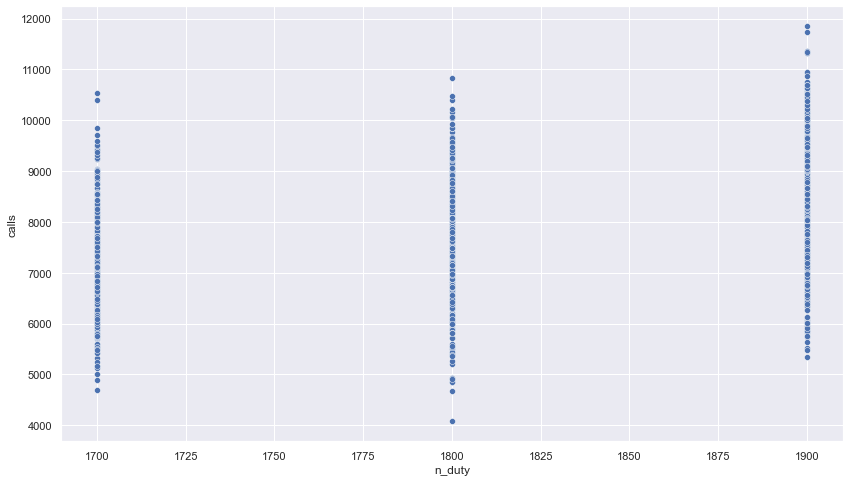

In [26]:
sns.scatterplot(x='n_duty', y='calls', data=df)

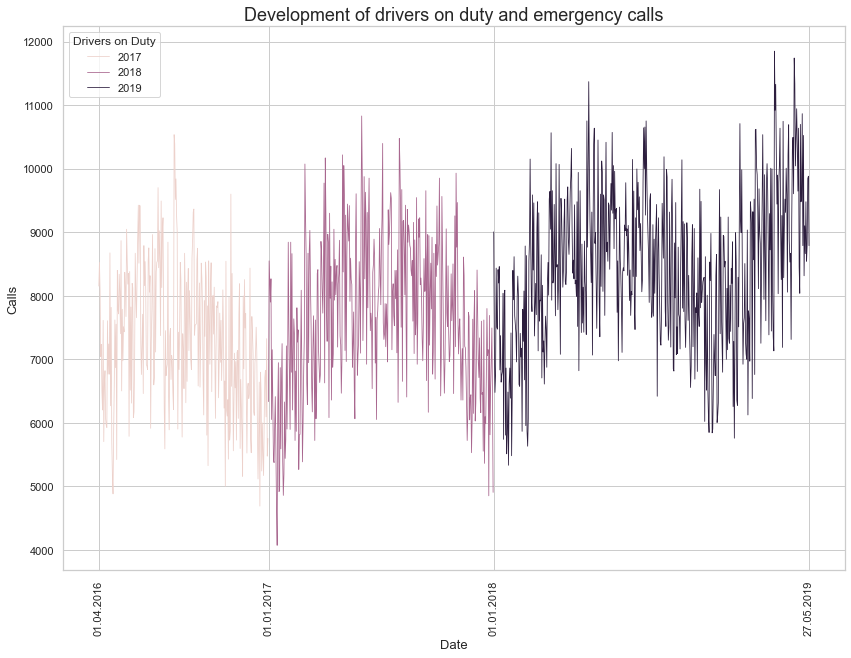

In [35]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='calls', hue='n_duty', data=df, linewidth = 0.8)
plt.xticks([0, 275, 640, 1151], ['01.04.2016', '01.01.2017', '01.01.2018', '27.05.2019'])
plt.xticks(rotation=90)

plt.legend(labels=["2017","2018", "2019"], title = "Drivers on Duty")
plt.xlabel('Date', fontsize=13)
plt.ylabel('Calls', fontsize=13)
plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.savefig("dev_n_duty_calls.svg")
plt.show()

How about calls and n_sick?

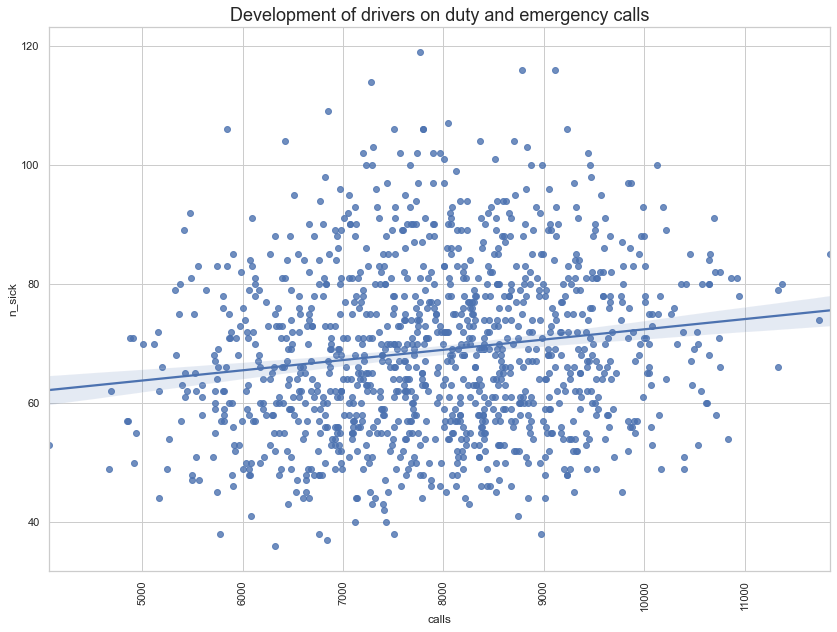

In [38]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.regplot(x='calls', y='n_sick', data=df)
plt.xticks(rotation=90)

plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.show()

If the number of calls increases, the number of sick drivers slightly increases

In [42]:
print(pearsonr(df.calls, df.n_sick)[0])

0.15537086860280808


In [43]:
print(pearsonr(df.calls, df.n_duty)[0])

0.36413536110780714


In [44]:
print(pearsonr(df.calls, df.sby_need)[0])

0.677467517263761


In [46]:
print(pearsonr(df.n_sick, df.sby_need)[0])

0.022321406858650947
